This Jupyter notebook is centered on calculating and storing descriptors for time series data using the `D2C` class from the `d2c.descriptors` module. It works with previously generated data stored in a directory and processes each file to extract time series descriptors. The notebook employs the Python libraries pandas and tqdm to manage and monitor data operations.

### Breakdown of the Notebook:

1. **Setup and Imports:**
   - Essential libraries like `pickle`, `os`, `pandas`, and `tqdm` are imported. Additionally, `D2C` and `DataLoader` from the `d2c.descriptors` module are used for processing the data.
   - Constants such as `N_JOBS` (number of parallel jobs), `SEED`, `MB_SIZE` (Markov blanket size), `COUPLES_TO_CONSIDER_PER_DAG`, and `maxlags` are defined for the descriptor calculations.

2. **Processing Each Data File:**
   - The notebook iterates over each file in the sorted order from the data directory. For each file, it extracts metadata like process number, number of variables, neighborhood size, and noise standard deviation from the filename.
   - A `DataLoader` instance is created and used to load the data from the respective file. The loaded data includes observations and DAGs (directed acyclic graphs) which represent the time series data and its underlying relationships.

3. **Descriptor Calculation:**
   - The `D2C` (Data to Causality) object is initialized with the loaded data and the predefined settings (like seed, number of jobs, etc.). The initialization prepares the framework for descriptor calculations.
   - Descriptors are computed for the data, which involves statistical and causal analysis to derive meaningful metrics that describe the interactions and dependencies within the data.

4. **Saving the Descriptors:**
   - The resulting dataframe containing descriptors is augmented with metadata columns indicating the process ID, number of variables, neighborhood size, and noise standard deviation.
   - The dataframe is then saved as a pickle file in a designated directory for descriptors. Each file is named systematically to reflect the configuration of the data it describes.

### Key Features:
- **Efficient Data Handling:** The notebook effectively handles large datasets by iterating through files and processing them individually, making efficient use of computational resources.
- **Progress Monitoring:** Integration of `tqdm` provides a progress bar for tracking the completion of processing across multiple files.
- **Detailed Metadata Management:** Metadata from filenames is used to annotate the descriptor results, ensuring that each output file is traceable back to its input conditions.

This notebook automates the computation of detailed descriptors for time series datasets, providing a scalable solution for analyzing large volumes of data in a structured and reproducible manner.

This notebook generates the training descriptors. 
For each file; only a subset of 300 couples of variables are chosen, according to the following logic

- 100 causal couples: A selection of 20 pairs of variables that are causally related according to the DAG. These serve as positive examples.
- 100 opposite couples: For each of the causal couples selected, the corresponding opposite pair (effect as cause and cause as effect) is also chosen. These pairs, despite being theoretically informative, do not respect the temporal ordering and thus they won't appear in the results returned by competitor methods. For this reason, they will be excluded from the evaluation phase later on, although they will remain in the training set of our classifier.
- 100 additional noncausal couples: To compensate for the exclusion of the opposite couples in validation and ensure a balanced dataset. Unlike the opposite ones, these pairs are chosen based on their lack of causal connection in the DAG and are more likely to resemble noncausal relationships encountered in real-world scenarios.

In [2]:
import pickle 
import os
import pandas as pd
from d2c.descriptors import D2C, DataLoader
from tqdm import tqdm

In [3]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 5 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = -1 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples

For which files do we want to compute our descriptors? We choose the ones with fixed `noise_std == 0.01`and fixed `max neighbordhood size==2`

In [11]:
input_folder = '../../data/'

to_process = []
for file in sorted(os.listdir(input_folder)):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)

Now we use the D2C method to compute the descriptors. <br>
We use `mb_estimator='ts'` to select the past and future values of the considered variable as its Markov Blanket <br>
We use `cmi='original'` to estimate conditional mutual information as in (Bontempi et al, 2015) <br>


In [4]:
# ETA 2h with 40 jobs!!

output_folder = './descriptors_ts_original_entropy/'  

#create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator='ts')

    d2c.initialize()

    descriptors_df = d2c.get_descriptors_df()

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

100%|██████████| 54/54 [1:54:53<00:00, 127.65s/it]  


Now we use `mb_estimator='ts'` to select the past and future values of the considered variable as its Markov Blanket <br>
We use `cmi='cmiknn'` to estimate conditional mutual information with knncmi <br>

In [7]:
# for this step it's required to clone the knncmi repository and install it
#
# git clone https://github.com/omesner/knncmi.git
# cd knncmi
# pip install .

ERROR: Could not find a version that satisfies the requirement knncmi (from versions: none)
ERROR: No matching distribution found for knncmi


In [10]:
to_process

['P13_N25_Nj2_n0.01.pkl',
 'P13_N5_Nj2_n0.01.pkl',
 'P14_N10_Nj2_n0.01.pkl',
 'P14_N25_Nj2_n0.01.pkl',
 'P14_N5_Nj2_n0.01.pkl',
 'P15_N10_Nj2_n0.01.pkl',
 'P15_N25_Nj2_n0.01.pkl',
 'P15_N5_Nj2_n0.01.pkl',
 'P16_N10_Nj2_n0.01.pkl',
 'P16_N25_Nj2_n0.01.pkl',
 'P16_N5_Nj2_n0.01.pkl',
 'P18_N10_Nj2_n0.01.pkl',
 'P18_N25_Nj2_n0.01.pkl',
 'P18_N5_Nj2_n0.01.pkl',
 'P19_N10_Nj2_n0.01.pkl',
 'P19_N25_Nj2_n0.01.pkl',
 'P19_N5_Nj2_n0.01.pkl',
 'P1_N10_Nj2_n0.01.pkl',
 'P1_N25_Nj2_n0.01.pkl',
 'P1_N5_Nj2_n0.01.pkl',
 'P20_N10_Nj2_n0.01.pkl',
 'P20_N25_Nj2_n0.01.pkl',
 'P20_N5_Nj2_n0.01.pkl',
 'P2_N10_Nj2_n0.01.pkl',
 'P2_N25_Nj2_n0.01.pkl',
 'P2_N5_Nj2_n0.01.pkl',
 'P3_N10_Nj2_n0.01.pkl',
 'P3_N25_Nj2_n0.01.pkl',
 'P3_N5_Nj2_n0.01.pkl',
 'P4_N10_Nj2_n0.01.pkl',
 'P4_N25_Nj2_n0.01.pkl',
 'P4_N5_Nj2_n0.01.pkl',
 'P6_N10_Nj2_n0.01.pkl',
 'P6_N25_Nj2_n0.01.pkl',
 'P6_N5_Nj2_n0.01.pkl',
 'P7_N10_Nj2_n0.01.pkl',
 'P7_N25_Nj2_n0.01.pkl',
 'P7_N5_Nj2_n0.01.pkl',
 'P8_N10_Nj2_n0.01.pkl',
 'P8_N25_Nj2_n0.01

In [9]:
output_folder = './descriptors_ts_cmiknn_entropy/'  

#create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# remove already processed files
to_process_copy = to_process.copy()
for file in os.listdir(output_folder):
    name = file[:-8]+file[-4:]
    if name in to_process_copy:
        to_process.remove(name)

In [12]:
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator='ts')

    d2c.initialize()

    descriptors_df = d2c.get_descriptors_df()

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

100%|██████████| 54/54 [19:17:00<00:00, 1285.57s/it]   


In [26]:
descriptors = {}
# for output_folder in ['./descriptors_original_full/','./descriptors_cmiknn_full/','./descriptors_cmiknn_full_k5/','./descriptors_cmiknn_full_k15/']:
for single_output_folder in [output_folder]:
    dfs = []
    for file in os.listdir(single_output_folder):
        df = pd.read_pickle(single_output_folder+file)
        dfs.append(df)
    descriptors[single_output_folder] = pd.concat(dfs)

In [6]:
descriptors[single_output_folder].columns

Index(['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size',
       'noise_std', 'edge_source', 'edge_dest', 'is_causal', 'coeff_cause',
       'coeff_eff', 'HOC_3_1', 'HOC_1_2', 'HOC_2_1', 'HOC_1_3', 'kurtosis_ca',
       'kurtosis_ef', 'mca_mef_cau_mean', 'mca_mef_cau_std',
       'mca_mef_eff_mean', 'mca_mef_eff_std', 'cau_m_eff_mean',
       'cau_m_eff_std', 'eff_m_cau_mean', 'eff_m_cau_std'],
      dtype='object')

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def perform_lopo_cv(descriptors_df):
    roc_aucs = {}
    for process_id in descriptors_df['process_id'].unique():
        df_test = descriptors_df[descriptors_df['process_id'] == process_id]
        df_train = descriptors_df[descriptors_df['process_id'] != process_id]

        X_train = df_train.drop(columns=['process_id','graph_id','n_variables','max_neighborhood_size','noise_std','edge_source','edge_dest','is_causal'])
        y_train = df_train['is_causal']

        X_test = df_test.drop(columns=['process_id','graph_id','n_variables','max_neighborhood_size','noise_std','edge_source','edge_dest','is_causal'])
        y_test = df_test['is_causal']

        clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=50, max_depth=None)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:,1]

        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs[process_id] = roc_auc
    return roc_aucs


# rocs = {}
# for key in descriptors.keys():
#     rocs[key] = perform_lopo_cv(descriptors[key])

In [27]:
#original mi, ts mb, less nj, a lot of couples 
perform_lopo_cv(descriptors[single_output_folder])


{7: 0.7346496295454545,
 9: 0.9999999958721312,
 8: 0.8800420282183986,
 13: 0.9304790771376101,
 15: 1.0,
 12: 1.0,
 6: 0.8345700080734272,
 3: 0.7262348246739156,
 14: 0.9619633094025584,
 18: 1.0,
 4: 0.7395588499544496,
 16: 0.9675956156500126,
 11: 0.916826456185331,
 2: 0.6362998744369714,
 19: 0.7526449394738874,
 20: 0.9548300895065012,
 1: 0.7902834331357759,
 10: 0.5495065550212876}

In [20]:
#original mi, original mb, less nj
perform_lopo_cv(descriptors[single_output_folder])


{13: 0.7718036458333334,
 9: 1.0,
 12: 1.0,
 15: 1.0,
 14: 0.889893576388889,
 7: 0.6795383680555556,
 20: 0.9708732638888888,
 2: 0.6144020833333333,
 11: 0.8296592013888888,
 19: 0.6974333333333332,
 1: 0.7514527777777777,
 18: 0.9999991319444445,
 6: 0.6110276041666667,
 3: 0.5078734375,
 8: 0.7127239583333332,
 10: 0.5244668402777777,
 4: 0.7756659722222223,
 16: 0.6832965277777777}

In [17]:
#original mi, original mb
perform_lopo_cv(descriptors[single_output_folder])


{13: 0.6948508680555556,
 3: 0.6176138888888889,
 16: 0.7191489583333334,
 11: 0.7411104166666668,
 19: 0.7364805555555554,
 14: 0.8402123263888889,
 7: 0.6366961805555554,
 4: 0.8018161458333334,
 9: 0.9999999999999999,
 20: 0.9368296875000001,
 10: 0.5418685763888889,
 15: 1.0,
 2: 0.6076519097222223,
 8: 0.7344494791666666,
 12: 1.0,
 18: 1.0,
 6: 0.6363486111111111,
 1: 0.8071034722222222}

In [14]:
#cmiknn, original mb
perform_lopo_cv(descriptors[single_output_folder])


{13: 0.8103199652777778,
 3: 0.7398005208333333,
 16: 0.8355258680555555,
 11: 0.8375675347222221,
 19: 0.8776675347222221,
 14: 0.9259642361111111,
 7: 0.8322111111111112,
 4: 0.7573314236111112,
 9: 1.0,
 20: 0.9328362847222222,
 10: 0.7239371527777777,
 15: 1.0,
 2: 0.7994038194444445,
 8: 0.8203859375,
 12: 1.0,
 18: 1.0,
 6: 0.7511479166666667,
 1: 0.7230802083333334}

In [8]:
#cmiknn, tsmb
perform_lopo_cv(descriptors[single_output_folder])


{13: 0.9126338541666668,
 3: 0.8677062065972223,
 16: 0.9743615885416667,
 11: 0.9687279513888889,
 19: 0.9536565104166665,
 14: 0.9889696180555555,
 7: 0.9126082899305556,
 4: 0.8582493489583334,
 9: 1.0,
 20: 0.9643254439621667,
 10: 0.9536603732638889,
 15: 1.0,
 2: 0.9014126302083333,
 8: 0.9321898003472222,
 12: 1.0,
 18: 0.9999999999999999,
 6: 0.9106546875,
 1: 0.8719641059027778}

In [5]:
perform_lopo_cv(descriptors['./descriptors_cmiknn_full_k3_mbts_MEDIUM_c60_notfull_quantiles/'])

{13: 0.912269357638889,
 3: 0.8691461805555556,
 16: 0.9755399305555555,
 11: 0.9684934461805556,
 19: 0.952733767361111,
 14: 0.9882985243055555,
 7: 0.9147229600694445,
 4: 0.8650696614583333,
 9: 1.0,
 20: 0.9665616582002423,
 10: 0.9543126736111112,
 15: 1.0,
 2: 0.9110377170138889,
 8: 0.9319425347222222,
 12: 1.0,
 18: 1.0,
 6: 0.9101961371527778,
 1: 0.8719449652777779}

In [10]:
perform_lopo_cv(descriptors['./descriptors_cmiknn_full_k3_mbts_MEDIUM_c60_notfull_quantiles/'])

{13: 0.9039194878472223,
 3: 0.8529528645833333,
 16: 0.9641472222222223,
 11: 0.9586094184027776,
 19: 0.9442946614583333,
 14: 0.9809096354166666,
 7: 0.9055210937500001,
 4: 0.8454918402777778,
 9: 1.0,
 20: 0.9131416682103205,
 10: 0.9441752604166667,
 15: 1.0,
 2: 0.8826792534722222,
 8: 0.9239776041666667,
 12: 1.0,
 18: 1.0,
 6: 0.9101336805555555,
 1: 0.8305375868055556}

In [ ]:
{13: 0.9317180555555555,
 3: 0.8845465277777778,
 16: 0.9710965277777778,
 11: 0.9660762152777778,
 19: 0.954526388888889,
 14: 0.9804326388888889,
 7: 0.9450670138888889,
 4: 0.9019128472222222,
 9: 1.0,
 20: 0.9452003472222222,
 10: 0.9563795138888889,
 15: 1.0,
 2: 0.9165769097222222,
 8: 0.9330982638888888,
 12: 1.0,
 18: 1.0,
 6: 0.928396875,
 1: 0.9210937499999999}

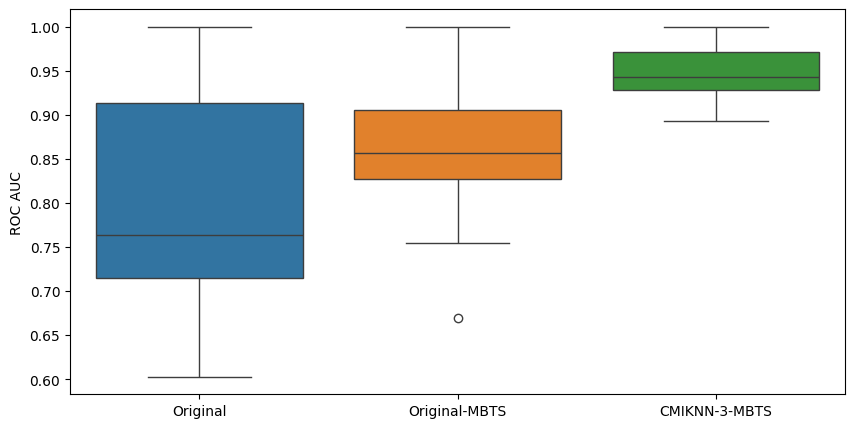

In [32]:
#plot results
import matplotlib.pyplot as plt
import seaborn as sns

rocs_df = pd.DataFrame(rocs)

plt.figure(figsize=(10,5))
sns.boxplot(data=rocs_df)
plt.ylabel('ROC AUC')
plt.xticks([0,1,2],['Original','Original-MBTS', 'CMIKNN-3-MBTS'])
plt.show()



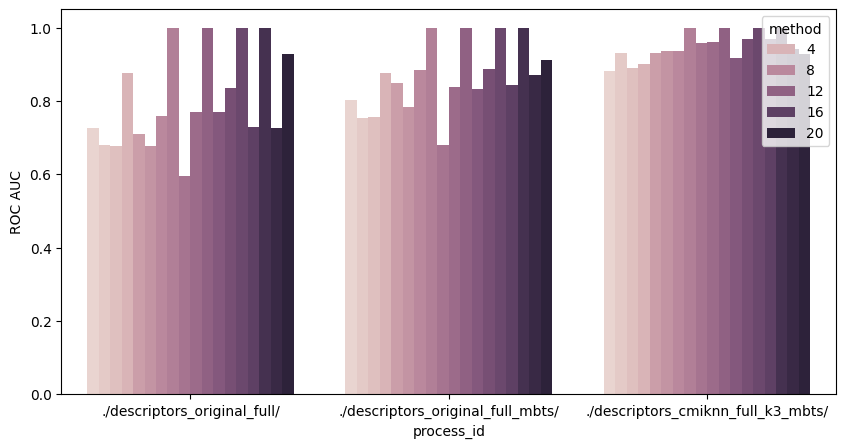

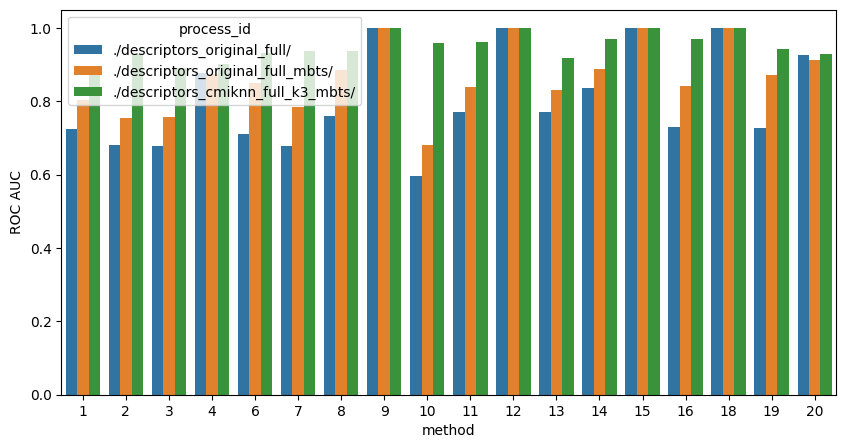

In [10]:
#barplot pairwise

rocs_df = pd.DataFrame(rocs)
rocs_df = rocs_df.T
rocs_df = rocs_df.reset_index()
rocs_df = rocs_df.melt(id_vars='index')
rocs_df.columns = ['process_id','method','roc_auc']

plt.figure(figsize=(10,5))
sns.barplot(data=rocs_df, x='process_id', y='roc_auc', hue='method')
plt.ylabel('ROC AUC')
plt.show()

# barplot same process_id side by side
rocs_df = pd.DataFrame(rocs)
rocs_df = rocs_df.T
rocs_df = rocs_df.reset_index()
rocs_df = rocs_df.melt(id_vars='index')
rocs_df.columns = ['process_id','method','roc_auc']

plt.figure(figsize=(10,5))
sns.barplot(data=rocs_df, x='method', y='roc_auc', hue='process_id')
plt.ylabel('ROC AUC')
plt.show()


In [64]:
# Some minor feature importance
from imblearn.ensemble import BalancedRandomForestClassifier
df = descriptors['./descriptors_cmiknn_full_k3_mbts/']

df_train = df[df['process_id'] >= 10]
df_test = df[df['process_id'] < 10]

X_train = df_train.drop(columns=['process_id', 'graph_id', 'n_variables','max_neighborhood_size','noise_std','edge_source','edge_dest','is_causal'])
y_train = df_train['is_causal']

X_test = df_test.drop(columns=['process_id', 'graph_id' ,'n_variables','max_neighborhood_size','noise_std','edge_source','edge_dest','is_causal'])
y_test = df_test['is_causal']

clf = BalancedRandomForestClassifier(n_estimators=50, random_state=42, n_jobs=50, sampling_strategy='all', replacement=True)
# clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

0.9014017089843751


In [14]:
import numpy as np
# Some minor feature importance
df = descriptors['./descriptors_cmiknn_full_k3_mbts_MEDIUM_c60_notfull/']

X = df.drop(columns=['process_id', 'graph_id', 'n_variables','max_neighborhood_size','noise_std','edge_source','edge_dest','is_causal'])
y = df['is_causal']


In [15]:

clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=50, max_depth=None)
clf.fit(X, y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f+1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")



Feature ranking:
1. feature mca_mef_eff_q4 (0.04881931165238239)
2. feature coeff_eff (0.048697141178605206)
3. feature mca_mef_cau_q6 (0.03825532701420078)
4. feature mca_mef_cau_q3 (0.036732126196339115)
5. feature mca_mef_eff_q5 (0.036568427771140284)
6. feature mca_mef_cau_q0 (0.035561596721655125)
7. feature mca_mef_eff_q6 (0.03504912096132223)
8. feature mca_mef_cau_q4 (0.03438708344607374)
9. feature coeff_cause (0.03269187982546781)
10. feature mca_mef_cau_q5 (0.031709072919983525)
11. feature kurtosis_ef (0.031155723060764032)
12. feature mca_mef_eff_q0 (0.03062405427260626)
13. feature kurtosis_ca (0.03051001836940786)
14. feature cau_m_eff_q6 (0.02954358213892277)
15. feature mca_mef_eff_q1 (0.029371573463101416)
16. feature mca_mef_cau_q1 (0.02928055894558546)
17. feature mca_mef_cau_q2 (0.0279036815176456)
18. feature cau_m_eff_q5 (0.027723311853059297)
19. feature HOC_3_1 (0.026516829707329794)
20. feature HOC_1_3 (0.025586044676101434)
21. feature HOC_2_1 (0.023785580495

In [16]:


df_train = df[df['process_id'] >= 10]
df_test = df[df['process_id'] < 10]

X_train = df_train.drop(columns=['process_id', 'graph_id', 'n_variables','max_neighborhood_size','noise_std','edge_source','edge_dest','is_causal'])
y_train = df_train['is_causal']


X_test = df_test.drop(columns=['process_id', 'graph_id' ,'n_variables','max_neighborhood_size','noise_std','edge_source','edge_dest','is_causal'])
y_test = df_test['is_causal']


# clf = BalancedRandomForestClassifier(n_estimators=50, random_state=42, n_jobs=50, sampling_strategy='all', replacement=True)
# # clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=50)
# clf.fit(X_train, y_train)

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=42, hidden_layer_sizes=(100, 100), max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

0.7895619642469618


In [17]:
#accuracy and other metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')


Accuracy: 0.7726041666666666
Precision: 0.7653966597077244
Recall: 0.45828125
F1: 0.5732994526974199


In [68]:
topick

Index(['mca_mef_cau_q6', 'mca_mef_cau_q3', 'mca_mef_cau_q4', 'mca_mef_cau_q5',
       'mbe_mbe_eff_q5', 'mca_mef_eff_q4', 'mca_mef_cau_q2', 'mbe_mbe_eff_q1',
       'mbe_mbe_eff_q0', 'mca_mef_eff_q5', 'mca_mef_eff_q6', 'mbe_mbe_eff_q3',
       'mbe_mbe_eff_q4', 'coeff_eff', 'mca_mef_cau_q1', 'mca_mef_eff_q3',
       'cau_m_eff_q6', 'cau_m_eff_q5', 'mbe_mbe_eff_q6', 'cau_m_eff_q4',
       'mbe_mbe_eff_q2', 'coeff_cause', 'mca_mef_cau_q0', 'kurtosis_ef',
       'cau_m_eff_q3', 'kurtosis_ca', 'HOC_1_3', 'HOC_2_1', 'cau_m_eff_q1',
       'cau_m_eff_q0', 'mca_mef_eff_q2', 'HOC_1_2', 'HOC_3_1',
       'mca_mef_eff_q0', 'eff_m_cau_q5', 'mca_mef_eff_q1', 'eff_m_cau_q2',
       'eff_m_cau_q4', 'eff_m_cau_q1', 'cau_m_eff_q2', 'eff_m_cau_q0',
       'eff_m_cau_q3', 'eff_m_cau_q6'],
      dtype='object')